In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pal = sns.color_palette("muted")
sns.set_style("whitegrid")

In [2]:
# Metadata from yeast v8.5.0 from SysBioChalmers
df_meta = pd.read_csv("yeast-GEM-meta.tsv", sep='\t').set_index("ID")
df_yeast = pd.read_csv("yeast-GEM.txt", sep='\t').set_index("Rxn name").join(df_meta[["SUBSYSTEM"]])
# M/A ratio of the metabolic genes, extracted from the txt file of the dataset (see notebook 01) and the yeast gem v8.5.0 gene set
df_expr = pd.read_csv("ma_ratio_metabolism.zip").set_index("systematicName")
df_yeast["count"] = 1
df_yeast['rxn_with_genes'] = df_yeast['Gene-reaction association'].apply(lambda x: 1 if pd.notna(x) and x != '' else 0)
pathway_labels = df_meta[["SUBSYSTEM"]].to_dict()['SUBSYSTEM']

In [3]:
df_meta.head()

,#,NAME,EQUATION,EC-NUMBER,GENE ASSOCIATION,LOWER BOUND,UPPER BOUND,OBJECTIVE,COMPARTMENT,MIRIAM,SUBSYSTEM,REPLACEMENT ID,NOTE,REFERENCE,CONFIDENCE SCORE
ID,,,,,,,,,,,,,,,
r_0001,NaN,(R)-lactate:ferricytochrome-c 2-oxidoreductase,(R)-lactate[c] + 2 ferricytochrome c[m] => 2 f...,1.1.2.4;1.1.99.-,(YDL174C and YEL039C) or (YDL174C and YJR048W)...,NaN,NaN,NaN,NaN,bigg.reaction/D_LACDcm;kegg.pathway/sce00620;k...,Pyruvate metabolism,NaN,MetaNetX ID curated (PR #220),NaN,2
r_0002,NaN,(R)-lactate:ferricytochrome-c 2-oxidoreductase,(R)-lactate[m] + 2 ferricytochrome c[m] => 2 f...,1.1.2.4;1.1.99.-,(YDL178W and YEL039C) or (YDL178W and YJR048W),NaN,NaN,NaN,NaN,bigg.reaction/D_LACDm;kegg.pathway/sce00620;ke...,Pyruvate metabolism,NaN,MetaNetX ID curated (PR #220),NaN,2
r_0003,NaN,"(R,R)-butanediol dehydrogenase","(R,R)-2,3-butanediol[c] + NAD[c] <=> (R)-aceto...",1.1.1.4,YAL060W,NaN,NaN,NaN,NaN,bigg.reaction/BTDD_RR;kegg.pathway/sce00650;ke...,Butanoate metabolism,NaN,NaN,NaN,2
r_0004,NaN,(S)-lactate:ferricytochrome-c 2-oxidoreductase,(S)-lactate[c] + 2 ferricytochrome c[m] => 2 f...,1.1.2.3,(YEL039C and YML054C) or (YJR048W and YML054C),NaN,NaN,NaN,NaN,bigg.reaction/L_LACD2cm;kegg.pathway/sce00620;...,Pyruvate metabolism,NaN,MetaNetX ID curated (PR #220),NaN,2
r_0005,NaN,"1,3-beta-glucan synthase",UDP-D-glucose[c] => (1->3)-beta-D-glucan[ce] +...,2.4.1.34,(YPR165W and YLR342W) or (YPR165W and YGR032W)...,NaN,NaN,NaN,NaN,kegg.pathway/sce00500;kegg.pathway/sce04011;ke...,Starch and sucrose metabolism,NaN,MetaNetX ID curated (PR #220),NaN,3


In [4]:
# Split the genes, filter by length, explode, remove duplicates, and group
df_groups = df_yeast.copy()
df_groups['genes'] = df_groups['Gene-reaction association'].str.replace('[()]', '', regex=True)
df_groups = df_groups.dropna()
df_groups['genes'] = df_groups['genes'].str.split(' ').apply(lambda x: [gene for gene in x if len(gene) > 3])
df_reaction_gene = df_groups.explode('genes').reset_index()[["Rxn name", "genes"]]
df_exploded = df_groups.explode('genes').drop_duplicates()

# Group by 'group' column and collect unique genes
df_exploded = df_exploded.groupby('SUBSYSTEM')['genes'].unique().reset_index()
df_exploded["n_genes"] = df_exploded["genes"].apply(lambda x: len(x))
df_exploded.sort_values(by="n_genes", ascending=False)

,SUBSYSTEM,genes,n_genes
69,"Transport [c, e]","[YCR024C-A, YEL017C-A, YGL008C, YPL036W, YER00...",120
45,Oxidative phosphorylation,"[Q0080, Q0085, Q0130, YBL099W, YBR039W, YDL004...",71
55,Purine metabolism,"[YGL248W, YOR360C, YOR155C, YGR061C, YNL141W, ...",54
31,Glycolysis / gluconeogenesis,"[YMR303C, YGL256W, YMR083W, YPL061W, YOR374W, ...",45
90,tRNA metabolism,"[YOR335C, YDR341C, YHR091C, YHR019C, YCR024C, ...",40
...,...,...,...
67,Threonylcarbamoyladenosine metabolism,[YGL169W],1
52,Phosphatidylinositol signaling system,[YDR017C],1
17,Cyclic nucleotide metabolism,[YGR247W],1
19,DNA repair,[YLR151C],1


Text(0.5, 0, 'Pathway')

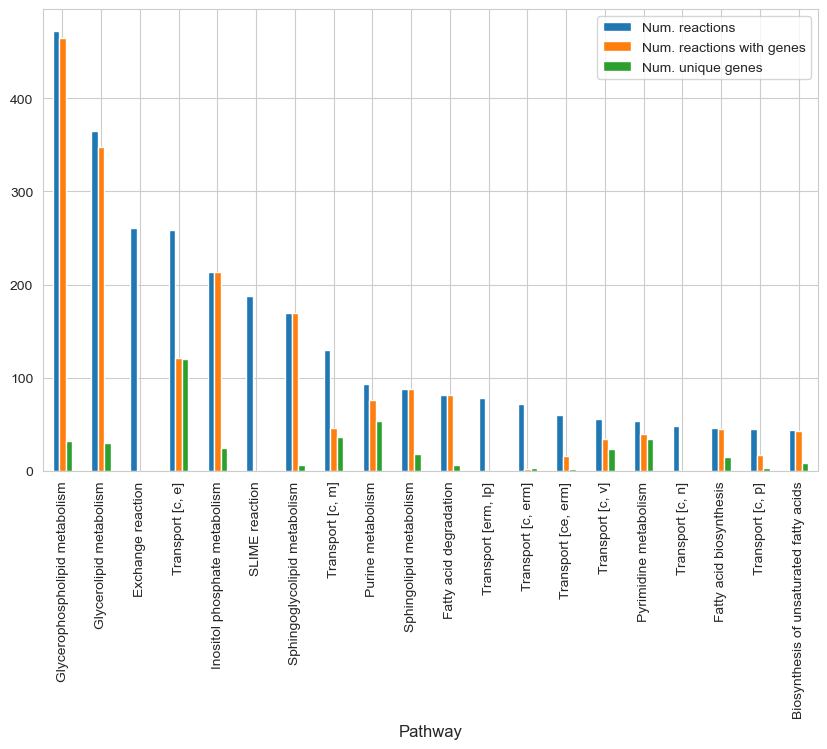

In [5]:
df_summary_pathways = df_yeast.groupby("SUBSYSTEM").sum()[["count", "rxn_with_genes"]].join(df_exploded.set_index("SUBSYSTEM")).drop("genes", axis=1)
df_summary_pathways.columns = ["n_reactions", "n_reactions_with_gpr", "n_unique_genes"]
df_summary_pathway_plot = df_summary_pathways.copy()
df_summary_pathway_plot.columns = ["Num. reactions", "Num. reactions with genes", "Num. unique genes"]
df_summary_pathway_plot = df_summary_pathway_plot.sort_values(by="Num. reactions", ascending=False)
ax=df_summary_pathway_plot.head(20).plot.bar(figsize=(10, 6))
ax.set_xlabel("Pathway", fontsize=12)

## Results

Here we analyze the results of inferring metabolic networks from standard iMAT vs the multicondition iMAT with lambda=1.5. The output files contain the fluxes per reaction.

In [6]:
def read_results(file):
    df_result = pd.read_csv(file).set_index("Rxn name")
    df_binary = (df_result.abs() >= 1e-6).astype(int)
    df_centered = df_binary.sub(df_binary.mean(axis=1), axis=0)
    return df_result, df_binary, df_centered

# Comparison between the solution with lambda=0 (single imat), vs lambda=1.5 (multi-condition imat using optimal lambda)
df_reg, df_regb, df_regc = read_results("output/result_l1.5_g0.1_flux.csv")
df_reg0, df_regb0, df_regc0 = read_results("output/result_l0_g0.1_flux.csv")

In [7]:
df_regb_pathway = df_regb.join(df_yeast[["SUBSYSTEM"]]).groupby("SUBSYSTEM").mean()
df_regb0_pathway = df_regb0.join(df_yeast[["SUBSYSTEM"]]).groupby("SUBSYSTEM").mean()

Text(0, 0.5, 'Proportion')

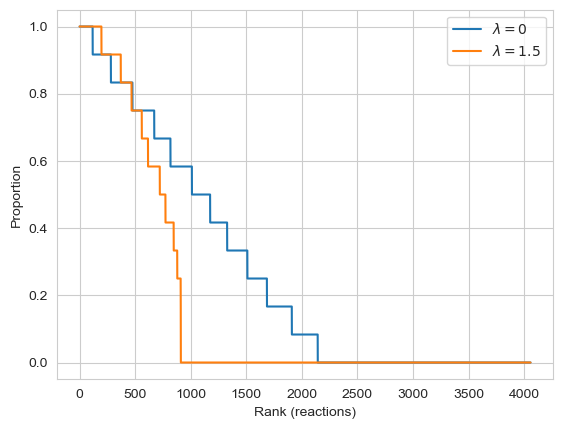

In [9]:
def df_reactions(list_rxn):
    df = pd.DataFrame([(r, pathway_labels.get(r, '')) for r in list_rxn], columns=["reaction", "pathway"])
    df["count"] = 1
    return df

df_prop_no_regularization = pd.DataFrame(df_regb0.mean(axis=1), columns=["lambda_0"])
df_prop_regularized = pd.DataFrame(df_regb.mean(axis=1), columns=["lambda_1.5"])

ax = df_prop_no_regularization.sort_values(by="lambda_0", ascending=False).reset_index(drop=True).join(
    df_prop_regularized.sort_values(by="lambda_1.5", ascending=False).reset_index(drop=True)
).plot()

ax.legend(labels=["$\lambda=0$", "$\lambda=1.5$"])
ax.set_xlabel("Rank (reactions)")
ax.set_ylabel("Proportion")

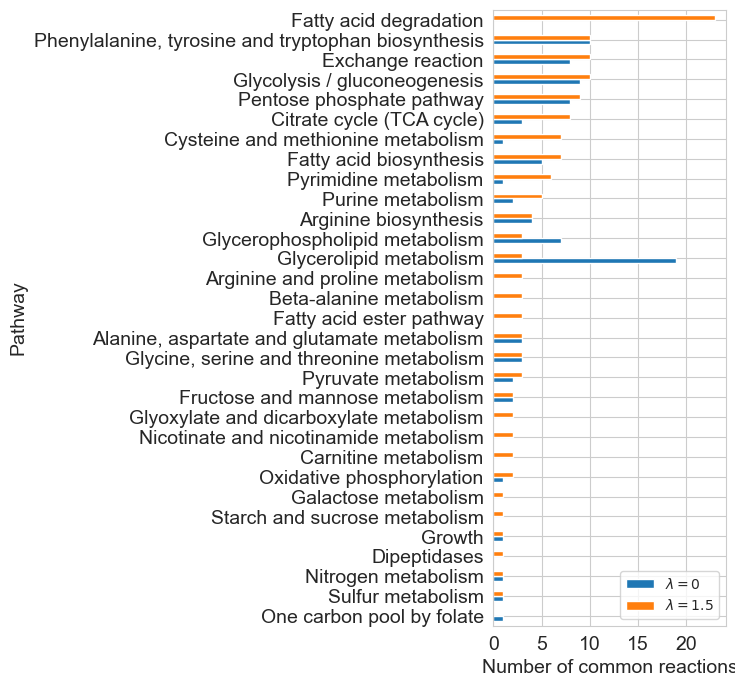

In [10]:
ix_noreg = df_prop_no_regularization[df_prop_no_regularization.lambda_0 >= 1].index
ix_reg = df_prop_regularized[df_prop_regularized["lambda_1.5"] >= 1].index
common_reactions = ix_noreg.intersection(ix_reg).tolist()

df_pathway_common_reg = df_reactions(ix_reg.tolist()).groupby("pathway").sum()
df_pathway_common_noreg = df_reactions(ix_noreg.tolist()).groupby("pathway").sum()
df_comp_common_pathways = df_pathway_common_noreg.join(df_pathway_common_reg, rsuffix='_reg', how="outer").fillna(0)
df_comp_common_pathways = df_comp_common_pathways[~df_comp_common_pathways.index.str.contains("Transport")].sort_values(by="count_reg", ascending=True)
ax = df_comp_common_pathways.plot.barh(figsize=(3,8), fontsize=14)
ax.legend(labels=["$\lambda=0$", "$\lambda=1.5$"])
#ax.set_title("Common reactions per pathway (for all conditions)")
ax.set_ylabel("Pathway", fontsize=14)
ax.set_xlabel("Number of common reactions", fontsize=14)

plt.savefig('output/diff_common_reacts_pathway_noreg_vs_reg.pdf', format='pdf', bbox_inches='tight')

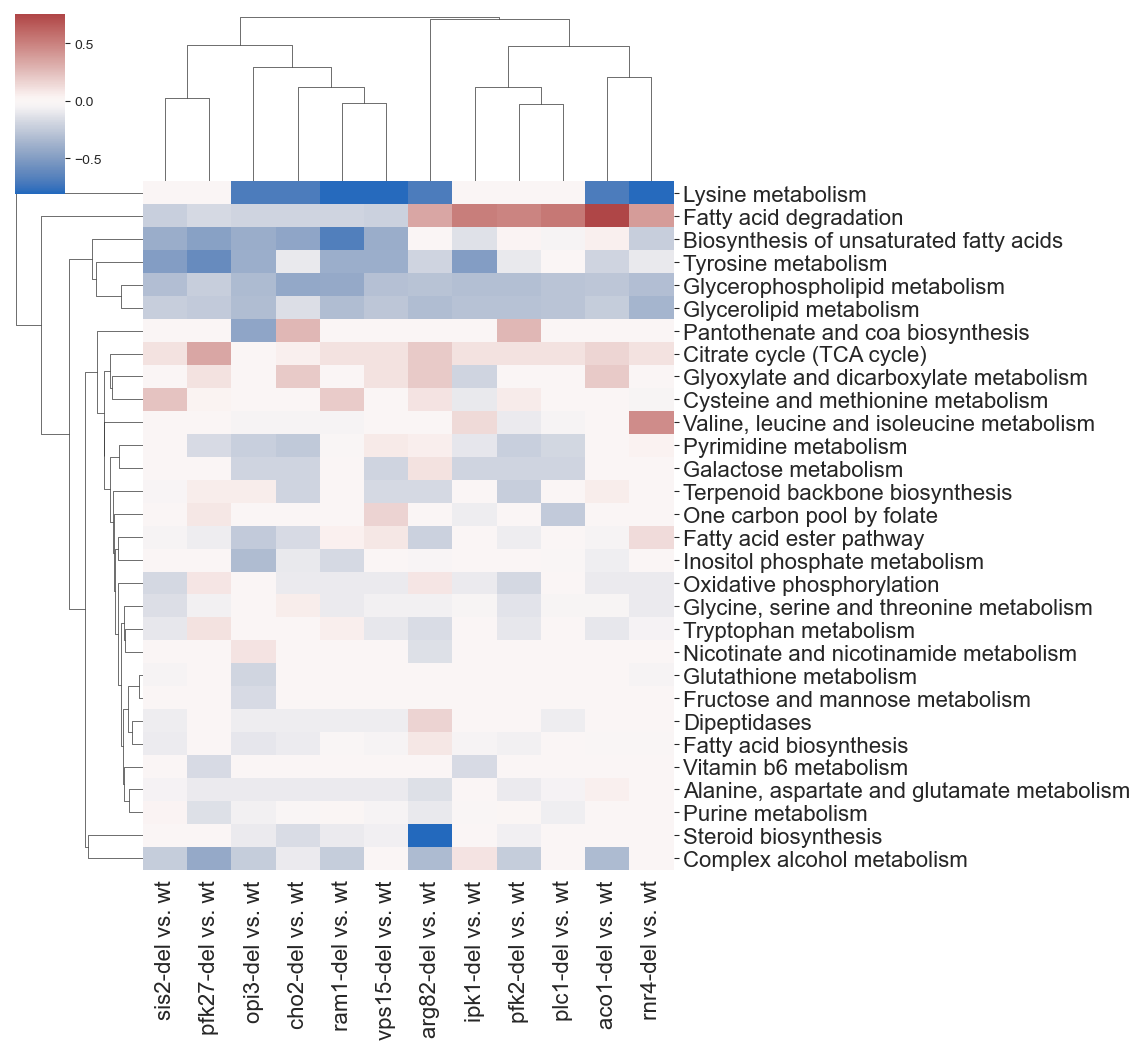

In [13]:
def clustermap(df, fontsize=16, show_xlabel=False, show_ylabel=False, cmap="vlag", top=None, center=0, **kwargs):
    dfc = df
    if top:
        dfc = dfc.loc[dfc.std(axis=1).sort_values(ascending=False).head(top).index, :]
    g = sns.clustermap(dfc, center=center, cmap=cmap, **kwargs)
    if not show_ylabel:
        g.ax_heatmap.set_ylabel("");
    if not show_xlabel:
        g.ax_heatmap.set_xlabel("");
    plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=16);
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=16);
    return g

diff_reactions = df_regb - df_regb0
diff_reactions = diff_reactions.join(df_yeast[["SUBSYSTEM"]]).groupby("SUBSYSTEM").mean()
diff_reactions = diff_reactions[~diff_reactions.index.str.contains("Transport")]
diff_reactions = diff_reactions.loc[diff_reactions.index.intersection(df_summary_pathways[df_summary_pathways.n_reactions >= 10].index)]
clustermap(diff_reactions, top=30, yticklabels=1)

plt.savefig('output/cluster_average_diff_per_pathway.pdf', format='pdf', bbox_inches='tight')